# Comparación de PHL con otros métodos de selección de instancias

In [11]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt

# Set path to the notebook directory (Jupyter compatible)

dbnames = ['pima',
           'drybeans',
           'diabetes_binary_5050split',
           'diabetes_binary'
]

dbpaths = ['../datasets/pima.csv',
           '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx',
           '../datasets/diabetes_health_indicators/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
           '../datasets/diabetes_health_indicators/diabetes_binary_health_indicators_BRFSS2015.csv'
]
targets = ['Outcome',
          'Class',
          'Diabetes_binary',
          'Diabetes_binary']

results_folders = ['../results/pima/',
                '../results/drybeans/',
                '../results/diabetes_binary_5050split/',
                '../results/diabetes_binary/']

In [12]:
def read_dataset(dbpath):
    if not os.path.exists(dbpath):
        print(f"{dbpath} does not exist.")
        return pd.DataFrame()

    # Load the dataset
    if dbpath.endswith('.xlsx') or dbpath.endswith('.xls'):
        # Read the Excel file
        df = pd.read_excel(dbpath, )
    else:
        # Read the CSV file
        df = pd.read_csv(dbpath)
    return df

dfs = [read_dataset(dbpath) for dbpath in dbpaths]
print("Tamaños de los datasets:")
for dbname, df in zip(dbnames, dfs):
    print(f"{dbname}: {df.shape}")

Tamaños de los datasets:
pima: (768, 9)
drybeans: (13611, 17)
diabetes_binary_5050split: (70692, 22)
diabetes_binary: (253680, 22)


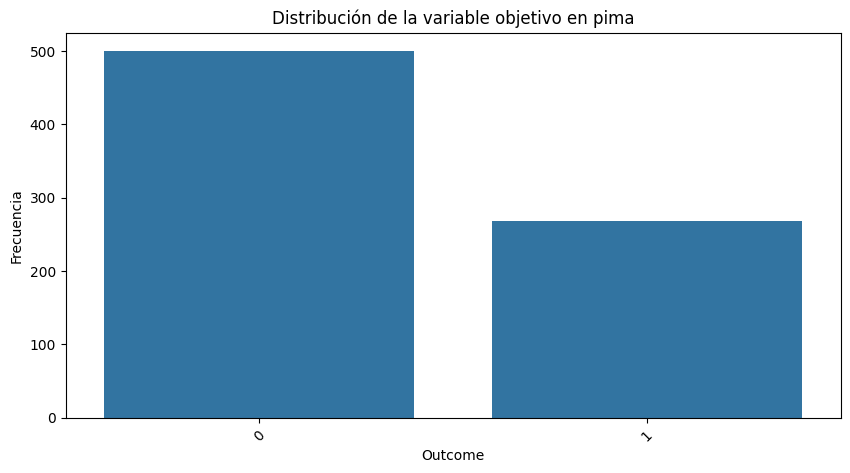

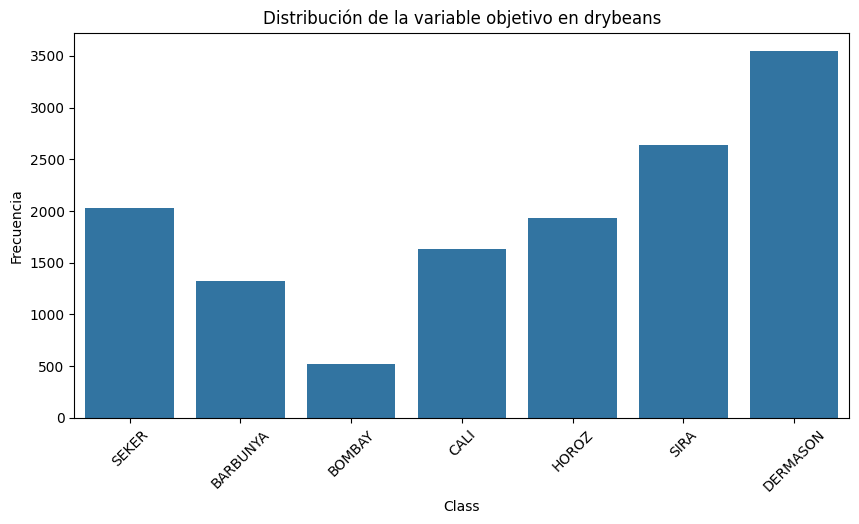

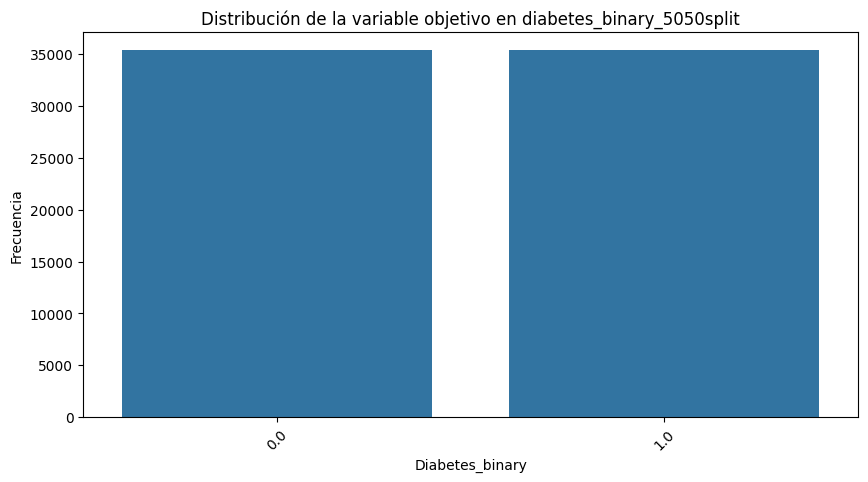

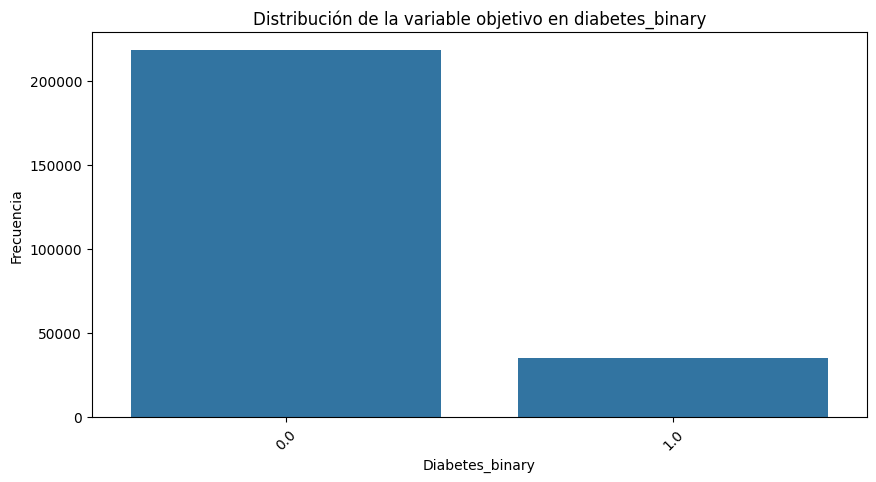

In [14]:
# Show bar plot of the target variable
for dbname, df, target in zip(dbnames, dfs, targets):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=target, data=df)
    plt.title(f'Distribución de la variable objetivo en {dbname}')
    plt.xlabel(target)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

## Comparación de métodos de selección de instancias

In [15]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
df_results = dict()
for dbname, results_folder in zip(dbnames, results_folders):
    df_results[dbname] = pd.read_csv(results_folder + 'results.csv')

### Dataset PIMA

In [16]:
results = df_results['pima']
results_folder = results_folders[0]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.714286,0.709411,0.002640,0.000000
1,RF,None,1.00,1.000000,0.000000,0.720779,0.714025,0.112176,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.753247,0.751855,0.047837,0.000000
3,KNN,SRS,0.05,0.048860,4.854175,0.681818,0.657571,0.000430,0.000667
4,KNN,SRS,0.10,0.097720,4.804304,0.655844,0.642750,0.000436,0.000634
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_V0_k=5,0.75,0.750814,3.722782,0.720779,0.715382,0.098404,0.023847
110,XGB,PHL_V0_k=5,0.75,0.750814,3.722782,0.701299,0.696202,0.035310,0.023847
111,KNN,PHL_V0_k=5,0.90,0.899023,3.006126,0.727273,0.722620,0.000746,0.023870
112,RF,PHL_V0_k=5,0.90,0.899023,3.006126,0.759740,0.757988,0.105080,0.023870


/tmp/ipykernel_18017/1958136264.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


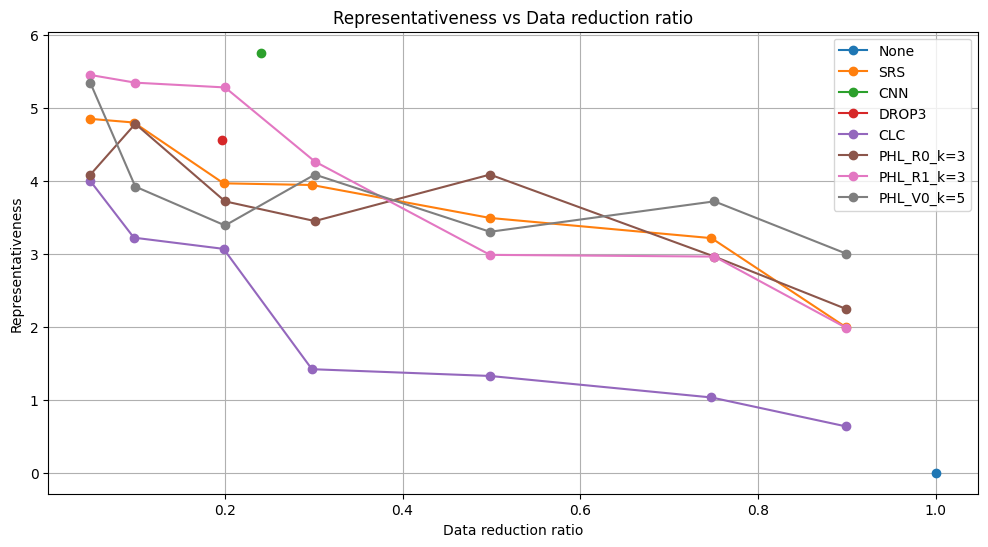

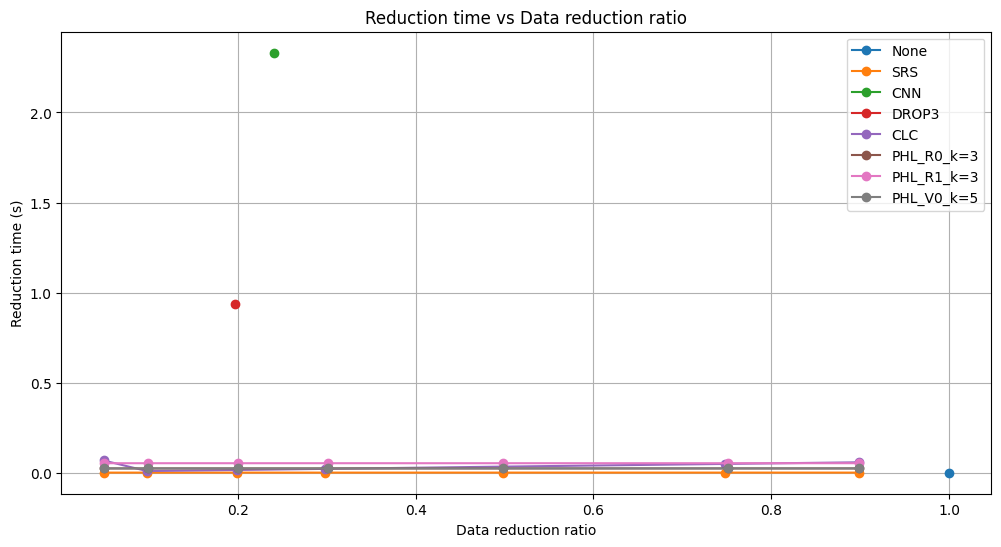

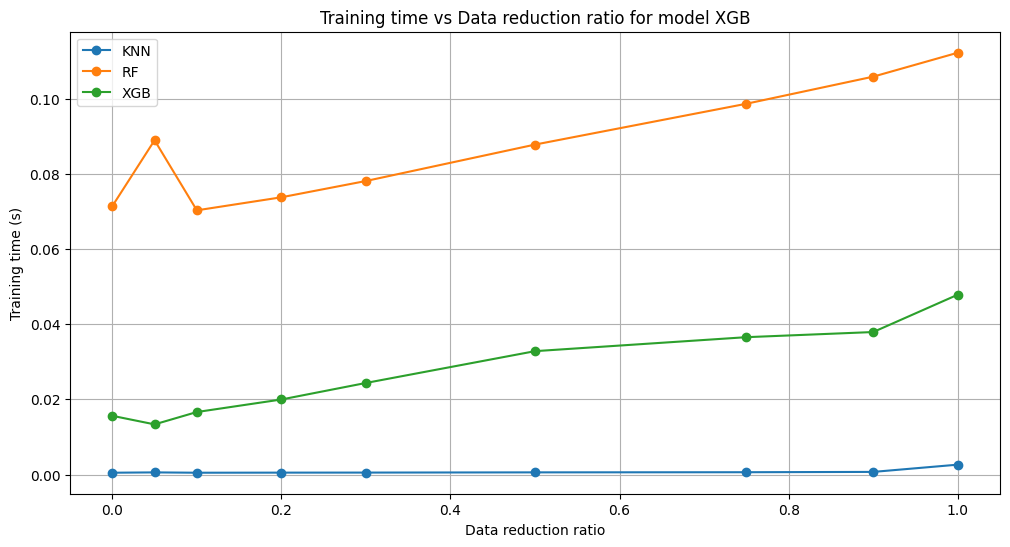

In [17]:
def plot_representativeness():
    mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()
    mean_training_time = results.groupby(['model', 'percentage'])['training_time'].mean().reset_index()

    # Plot representativeness vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                mean_results[mean_results['reduction_method'] == reduction_method]['representativeness'],
                label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
    plt.show()

    # Plot reduction time vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                mean_results[mean_results['reduction_method'] == reduction_method]['reduction_time'],
                label=reduction_method, marker='o')
    plt.title(f'Reduction time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
    plt.show()

    # Plot training time vs percentage averaged by reduction method
    plt.figure(figsize=(12, 6))
    mean_training_time
    for model_name in results['model'].unique():
        plt.plot(mean_training_time[mean_training_time['model'] == model_name]['percentage'],
                mean_training_time[mean_training_time['model'] == model_name]['training_time'],
                label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
    plt.show()

plot_representativeness()

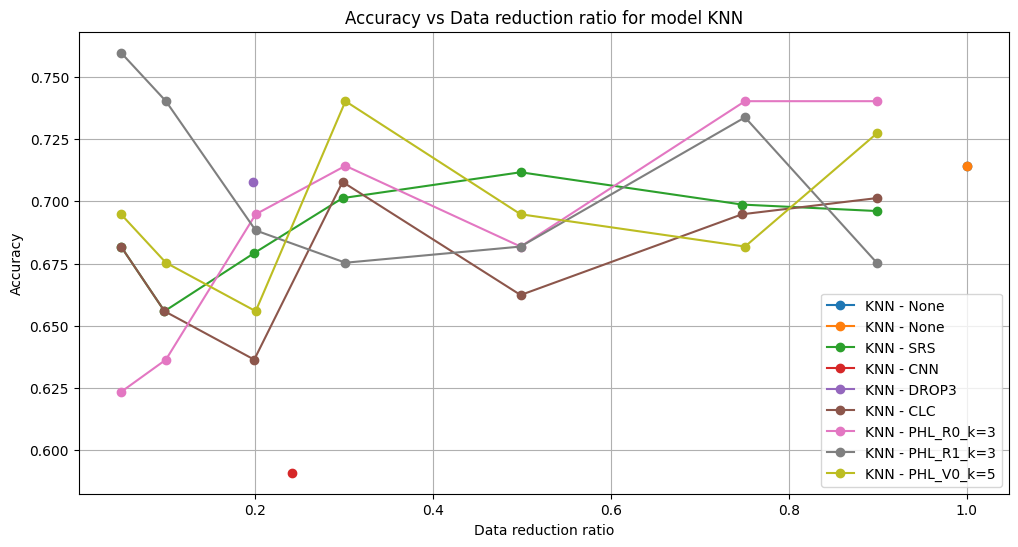

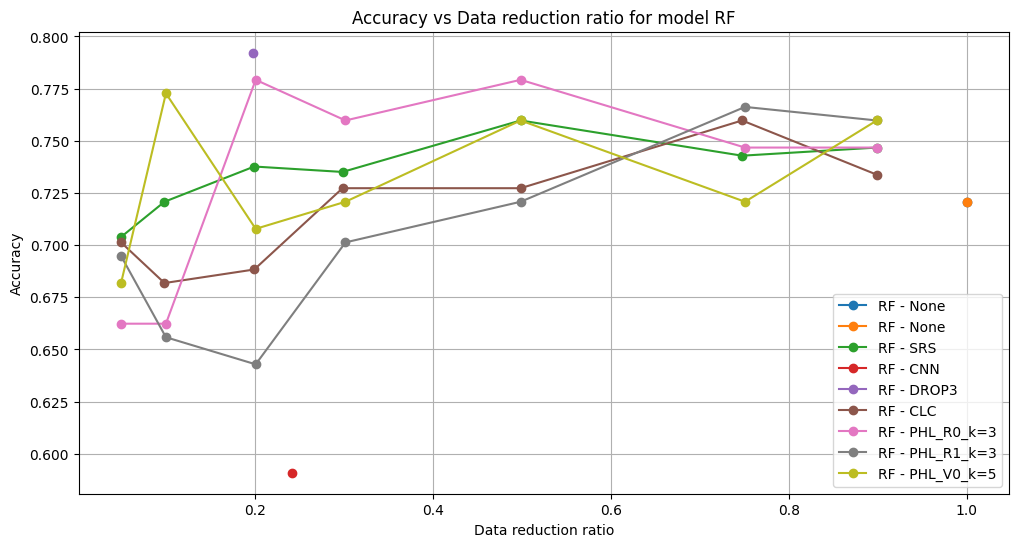

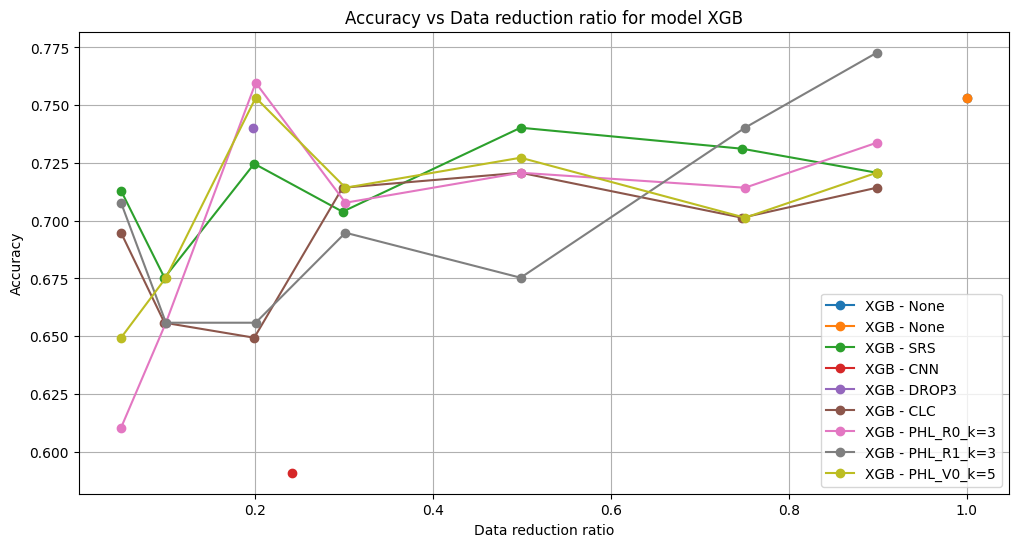

In [18]:
def plot_accuracy():
    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
                results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
                label=f'{model_name} - None', marker='o')
        for reduction_method in results['reduction_method'].unique():
            plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                    results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                    label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
        plt.show()
        
plot_accuracy()

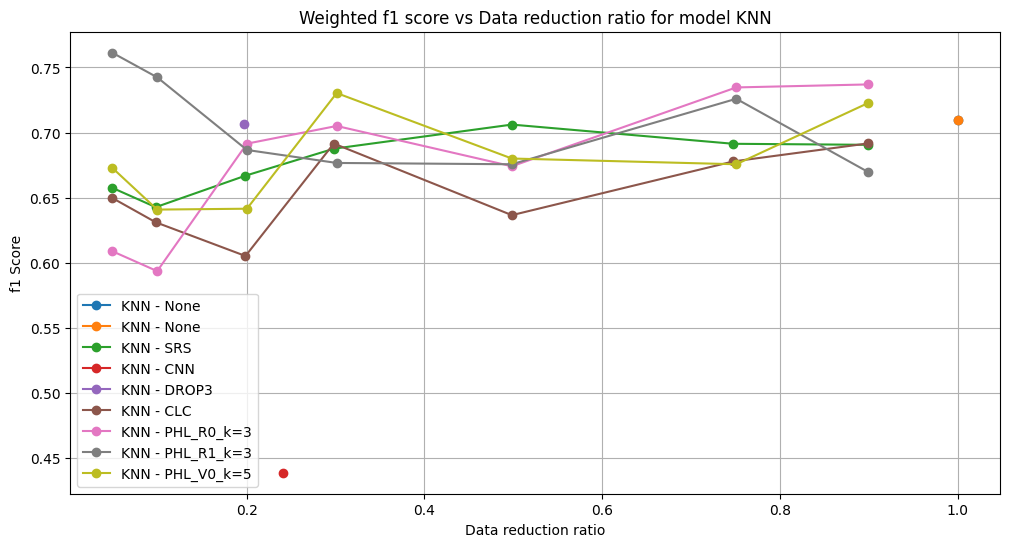

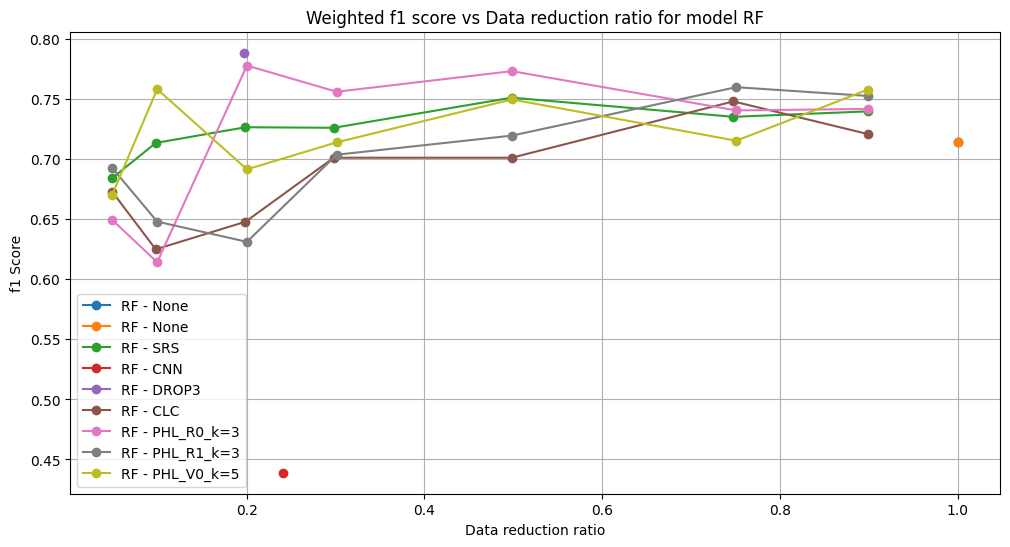

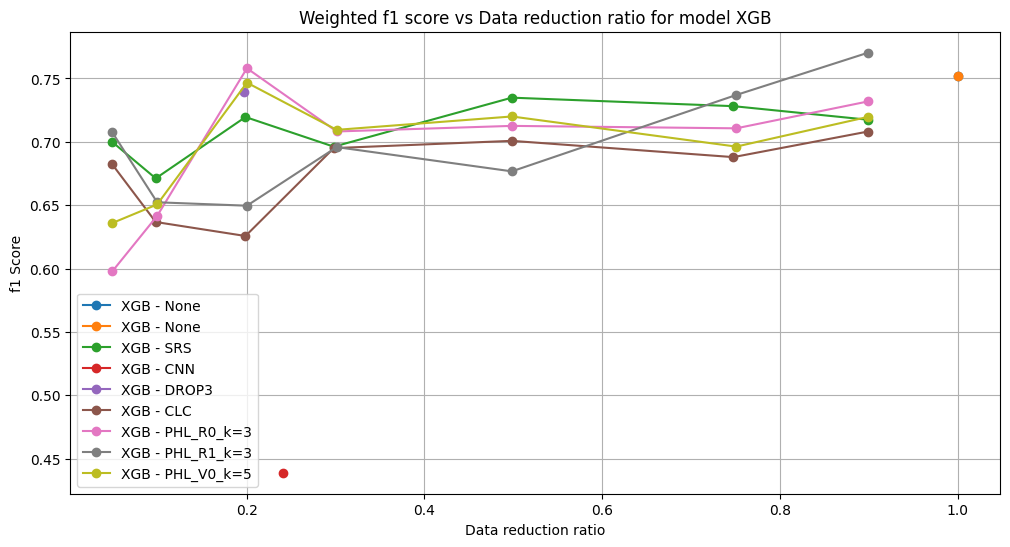

In [19]:
def plot_f1():
    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
                results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
                label=f'{model_name} - None', marker='o')
        for reduction_method in results['reduction_method'].unique():
            plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                    results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                    label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
        # plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
        plt.show()

plot_f1()

### Dataset DryBeans

In [20]:
results = df_results['drybeans']
results_folder = results_folder[1]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.918840,0.919008,0.001098,0.000000
1,RF,None,1.00,1.000000,0.000000,0.922879,0.922812,3.373983,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.920676,0.920778,0.518108,0.000000
3,KNN,SRS,0.05,0.049596,13.460832,0.899008,0.899391,0.000388,0.003576
4,KNN,SRS,0.10,0.099743,10.810566,0.902167,0.902509,0.000388,0.003558
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_R0_k=3,0.75,0.750000,2.156773,0.923981,0.923978,2.329308,0.837308
110,XGB,PHL_R0_k=3,0.75,0.750000,2.156773,0.923614,0.923791,0.451316,0.837308
111,KNN,PHL_R0_k=3,0.90,0.900073,1.935758,0.917371,0.917521,0.000875,0.837620
112,RF,PHL_R0_k=3,0.90,0.900073,1.935758,0.921043,0.921047,2.978482,0.837620


/tmp/ipykernel_18017/1958136264.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


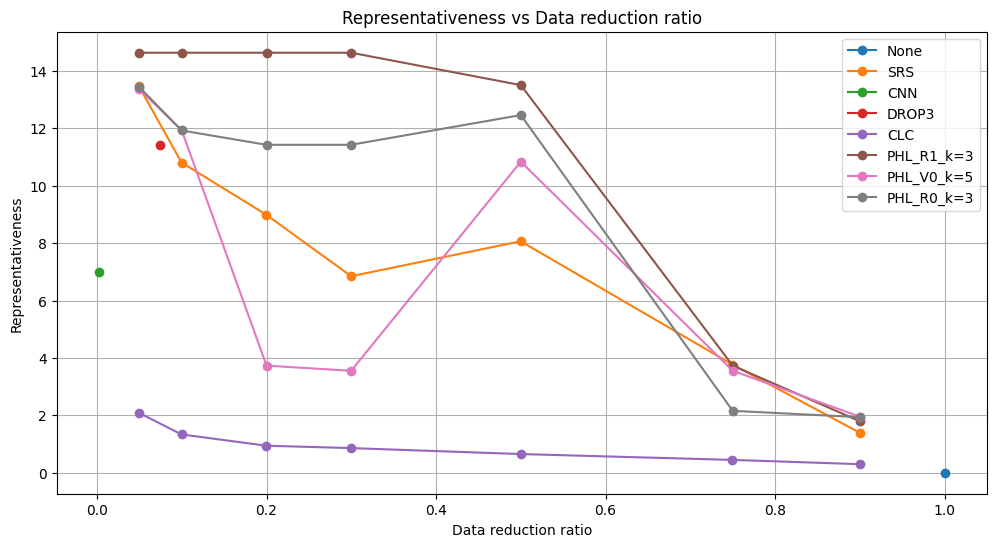

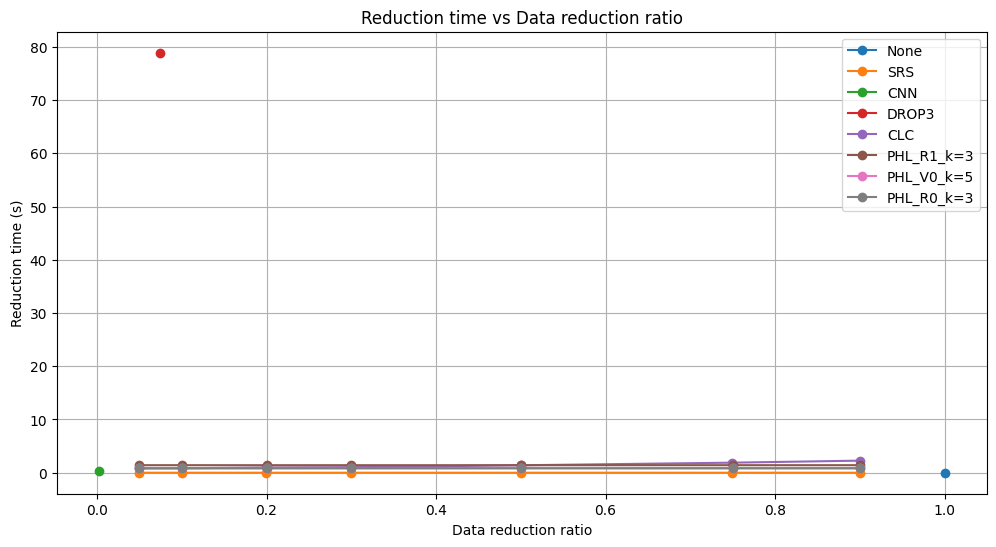

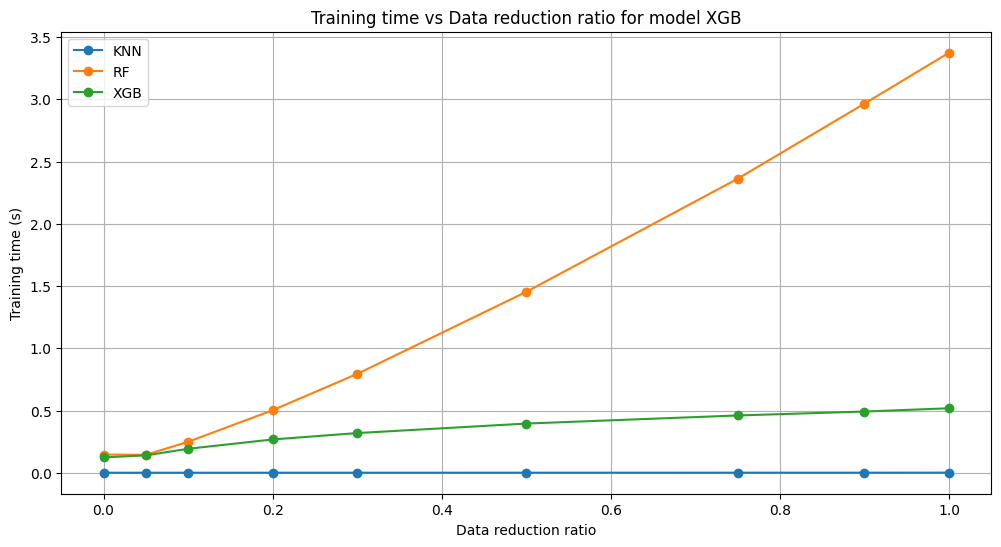

In [21]:
plot_representativeness()

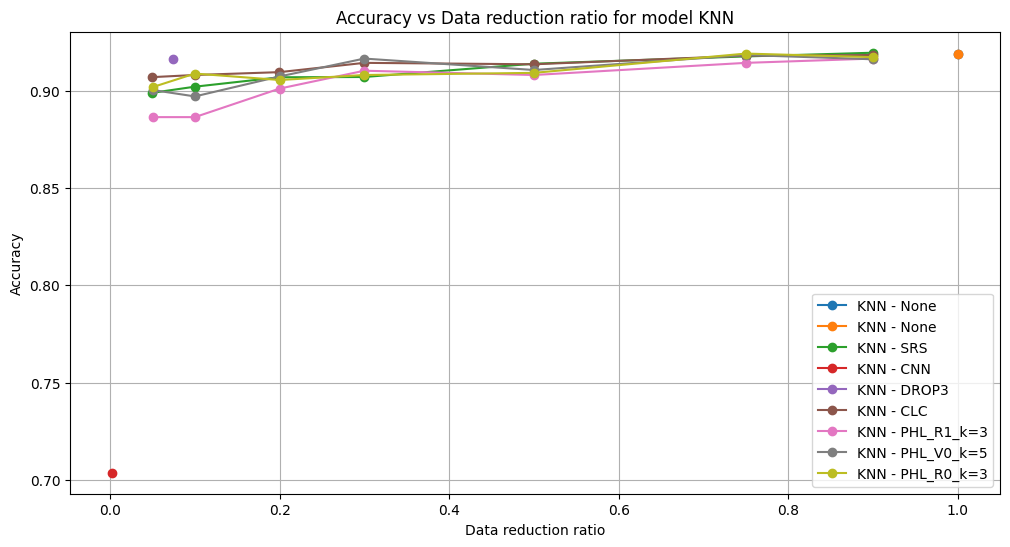

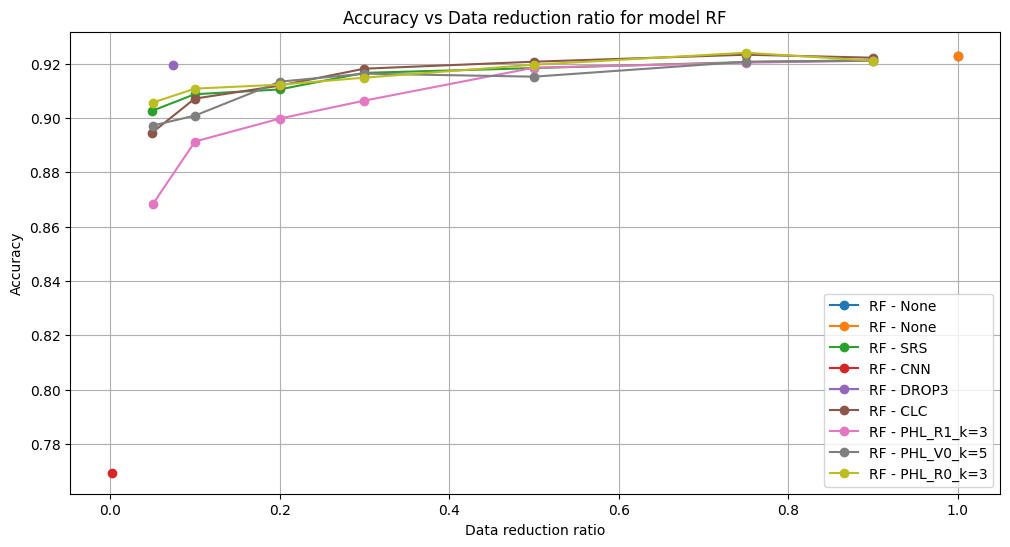

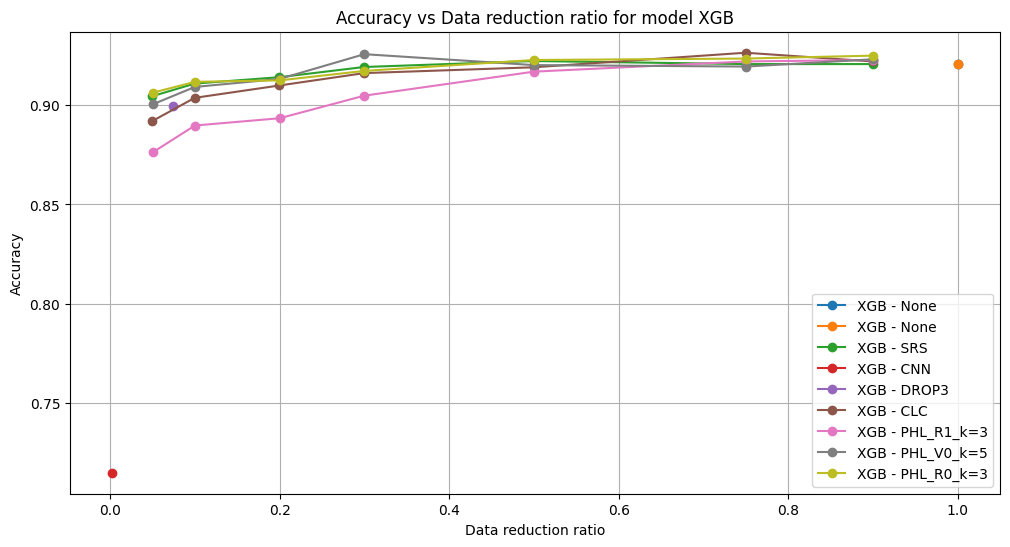

In [22]:
plot_accuracy()

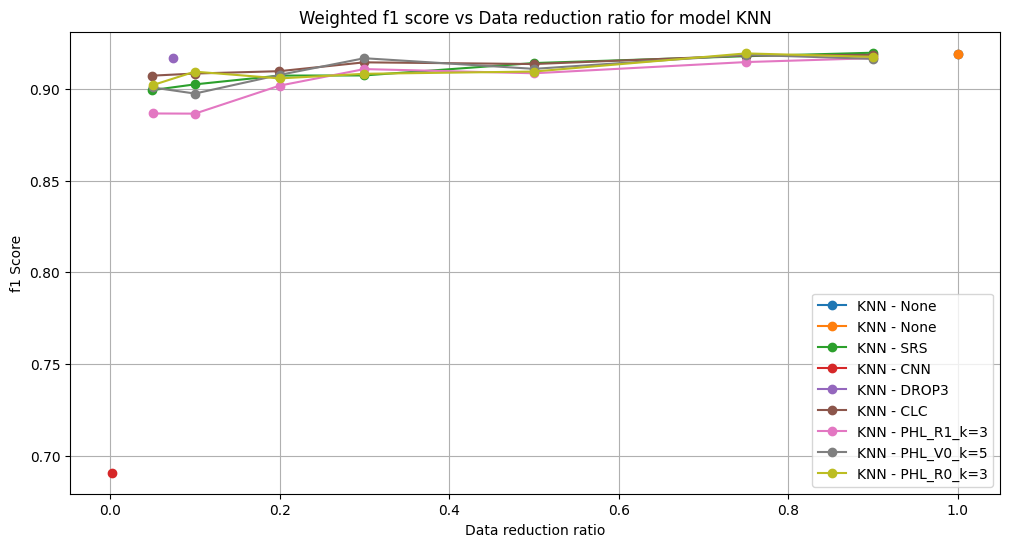

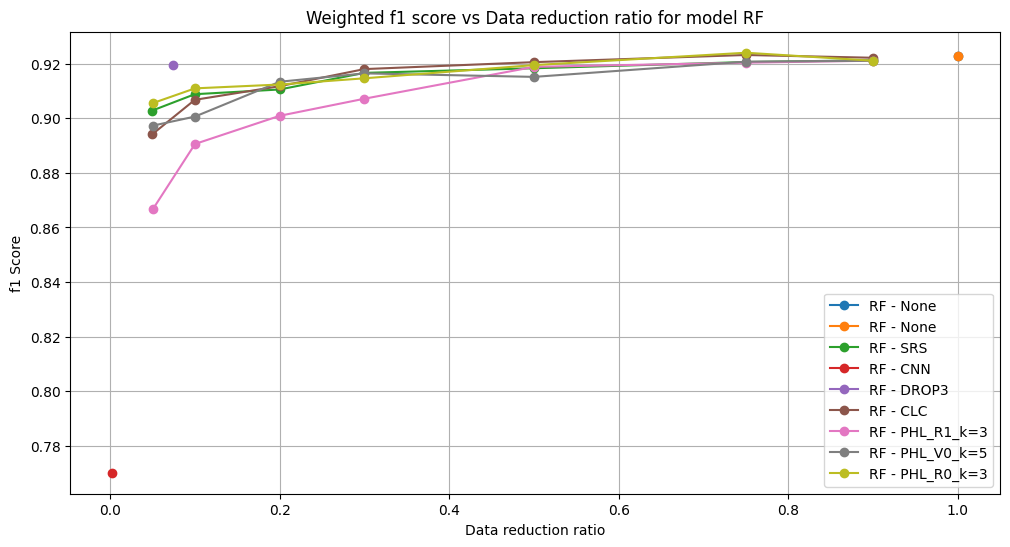

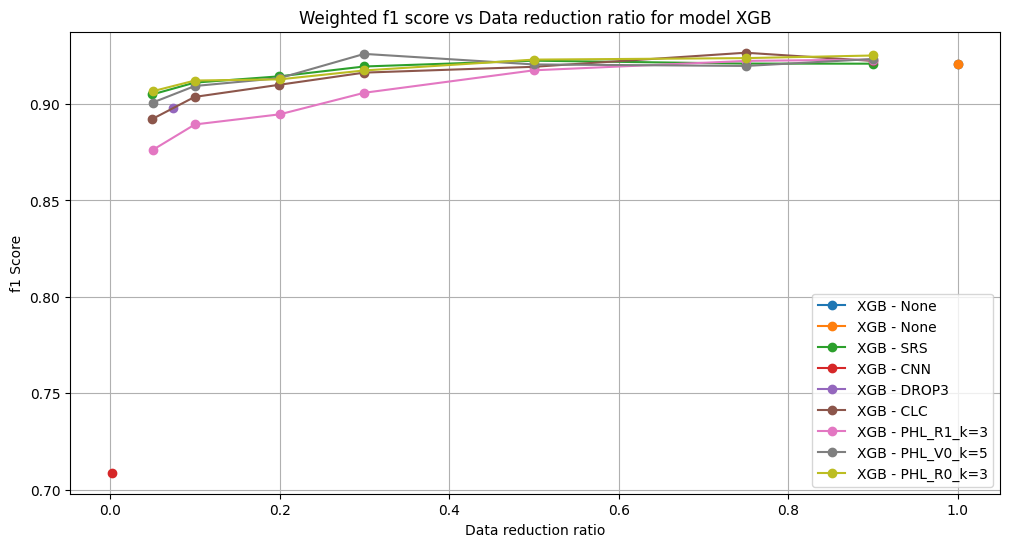

In [23]:
plot_f1()

### Dataset Diabetes binary 5050split

In [24]:
results = df_results['diabetes_binary_5050split']
results_folder = results_folders[2]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.693472,0.693427,0.003168,0.000000
1,RF,None,1.00,1.000000,0.000000,0.741920,0.741696,4.313907,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.747295,0.747000,0.144699,0.000000
3,KNN,SRS,0.05,0.049989,6.304665,0.689964,0.689944,0.000520,0.015458
4,KNN,SRS,0.10,0.099995,5.077813,0.694363,0.694333,0.000594,0.015420
...,...,...,...,...,...,...,...,...,...
103,RF,PHL_R0_k=3,0.75,0.749987,4.816520,0.739090,0.738877,3.052954,49.825010
104,XGB,PHL_R0_k=3,0.75,0.749987,4.816520,0.750690,0.750409,0.105758,49.825010
105,KNN,PHL_R0_k=3,0.90,0.900005,3.441800,0.693543,0.693516,0.002724,49.826529
106,RF,PHL_R0_k=3,0.90,0.900005,3.441800,0.741142,0.740949,3.668444,49.826529


/tmp/ipykernel_18017/1958136264.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


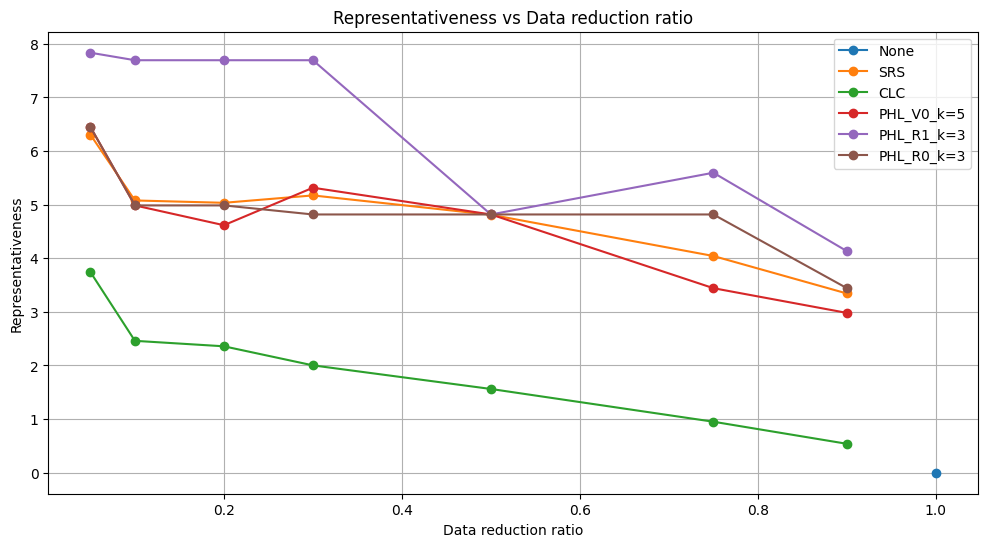

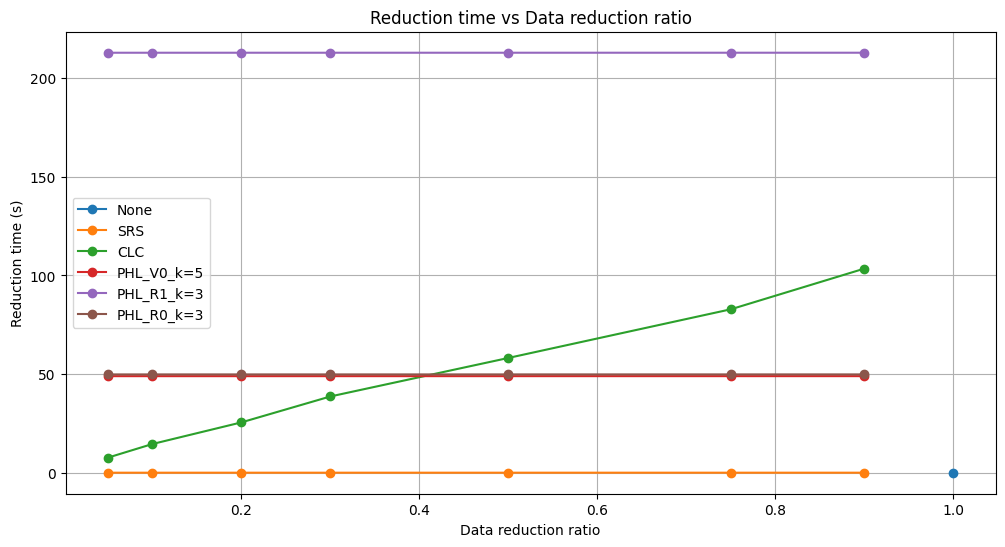

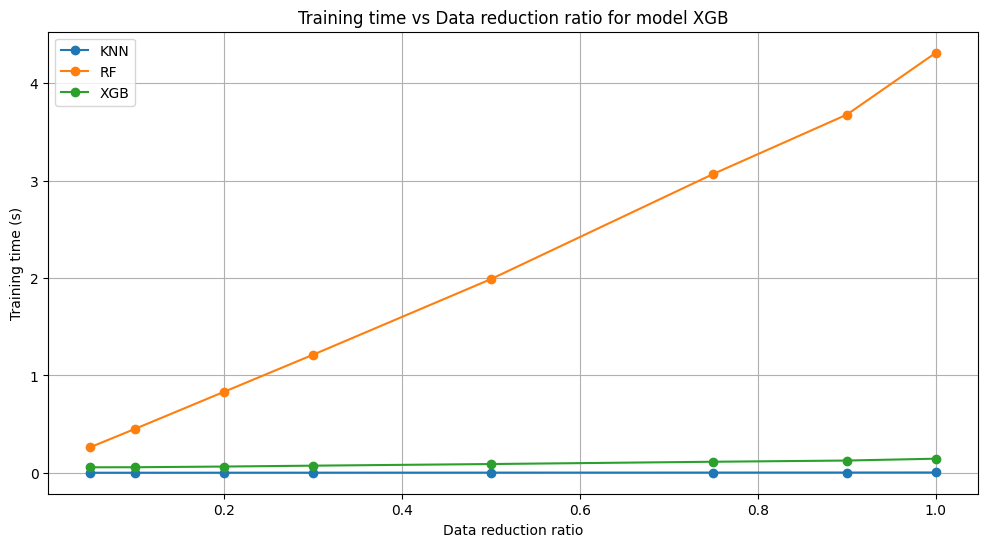

In [25]:
plot_representativeness()

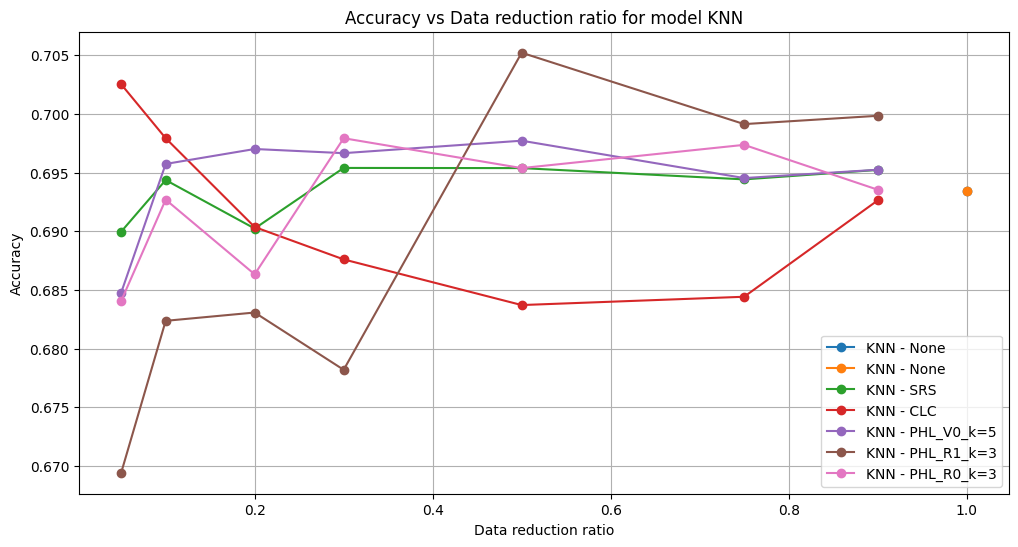

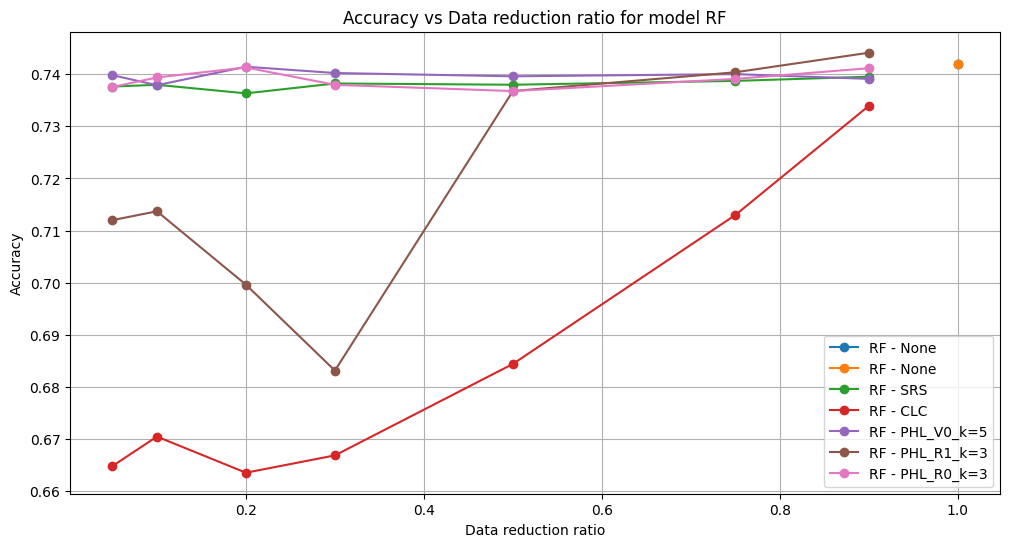

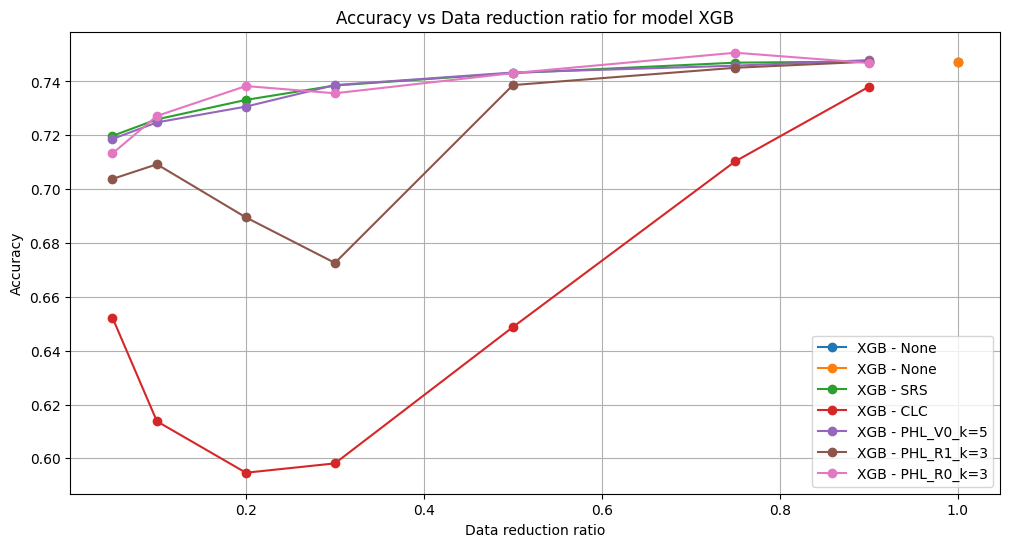

In [26]:
plot_accuracy()

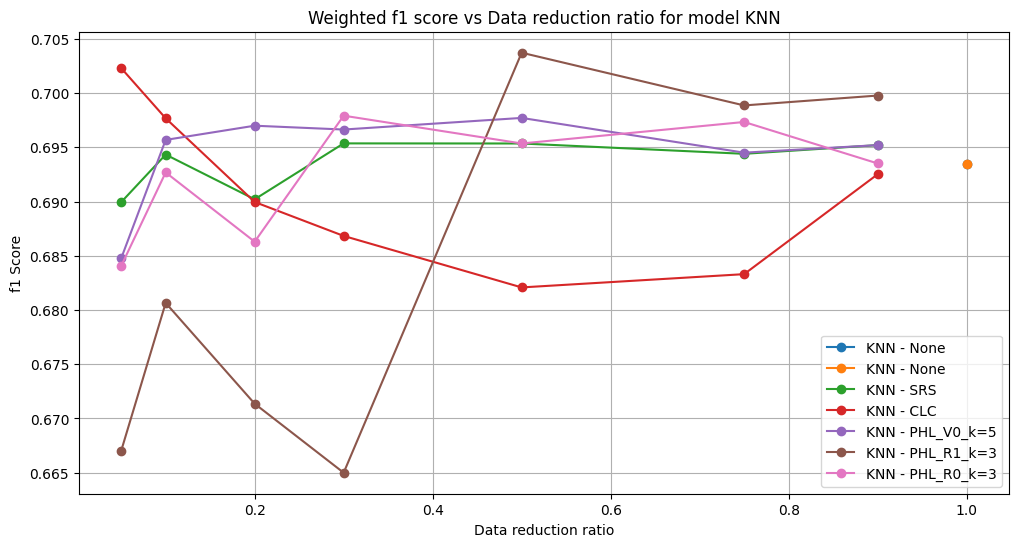

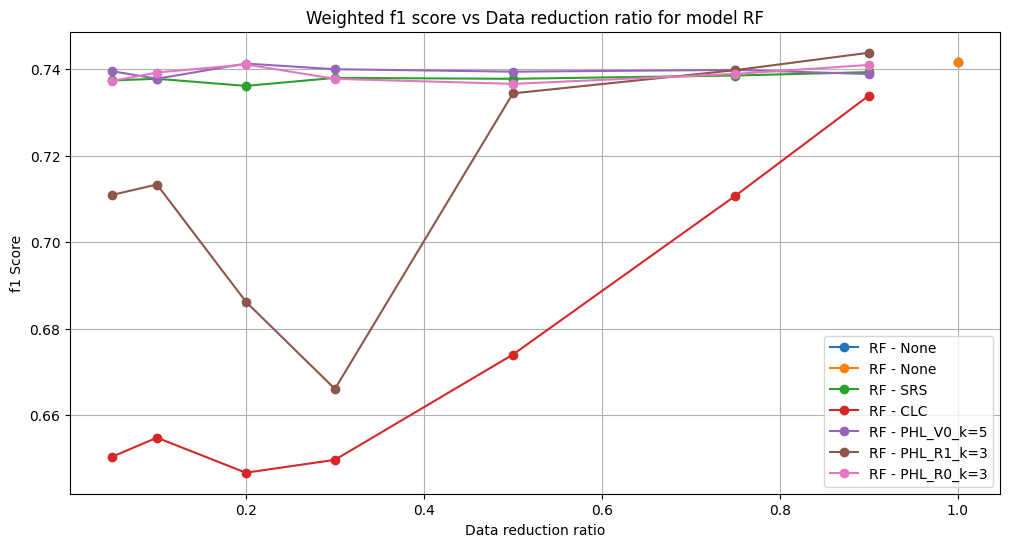

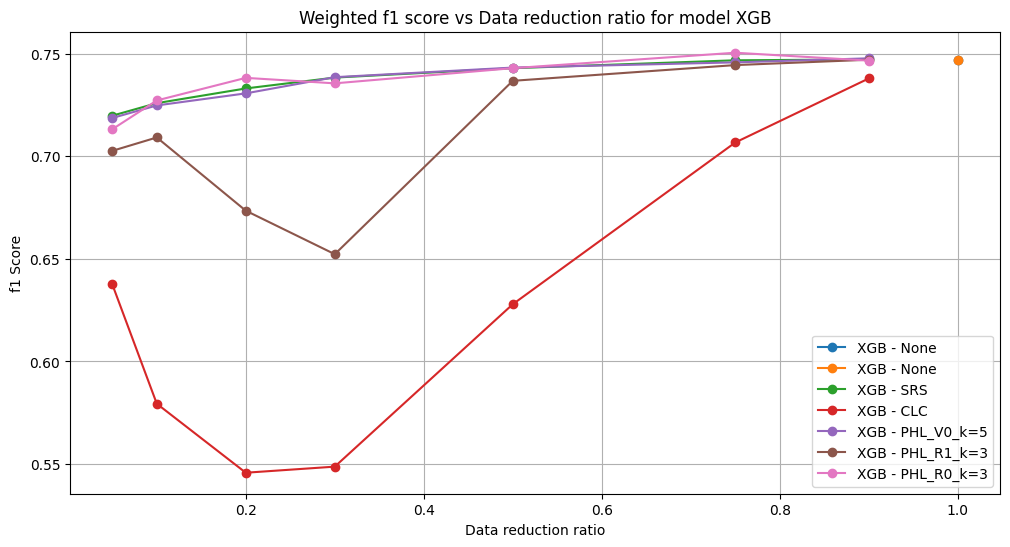

In [27]:
plot_f1()

### Dataset Diabetes binary

In [28]:
results = df_results['diabetes_binary']
results_folder = results_folders[3]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.836112,0.822133,0.011049,0.000000
1,RF,None,1.00,1.000000,0.000000,0.860907,0.831341,18.938280,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.865717,0.833687,0.451221,0.000000
3,KNN,SRS,0.05,0.049994,5.234557,0.835391,0.818343,0.000734,0.053758
4,KNN,SRS,0.10,0.099998,4.892962,0.835494,0.819705,0.001060,0.054629
5,KNN,SRS,0.20,0.199996,4.918395,0.837137,0.821480,0.001667,0.056398
6,KNN,SRS,0.30,0.299999,4.863441,0.836830,0.821832,0.002328,0.058459
7,KNN,SRS,0.50,0.500000,4.269767,0.836459,0.821480,0.003604,0.062163
8,KNN,SRS,0.75,0.749995,3.700792,0.836246,0.821756,0.005240,0.065949
9,KNN,SRS,0.90,0.899997,3.530691,0.836767,0.822381,0.006412,0.068743


/tmp/ipykernel_18017/1958136264.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


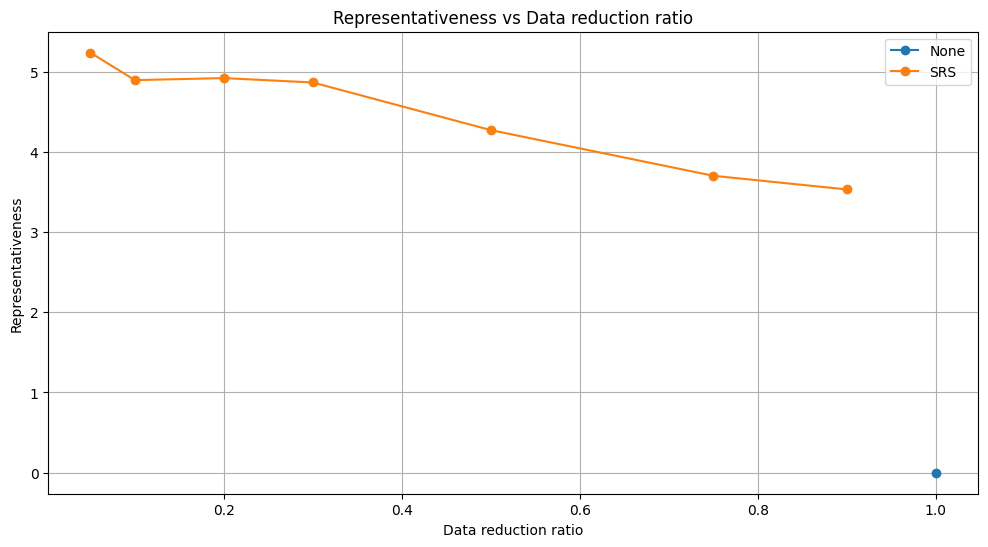

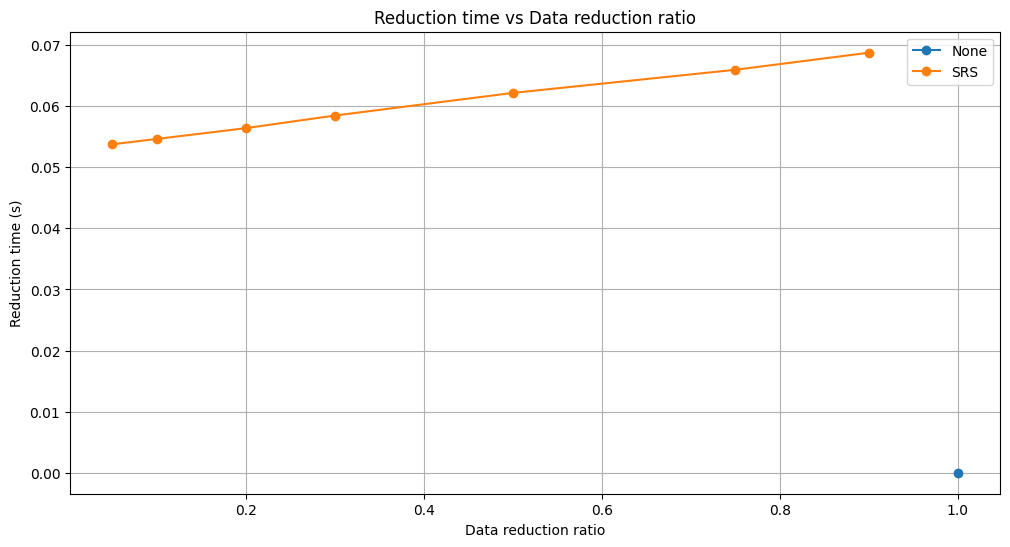

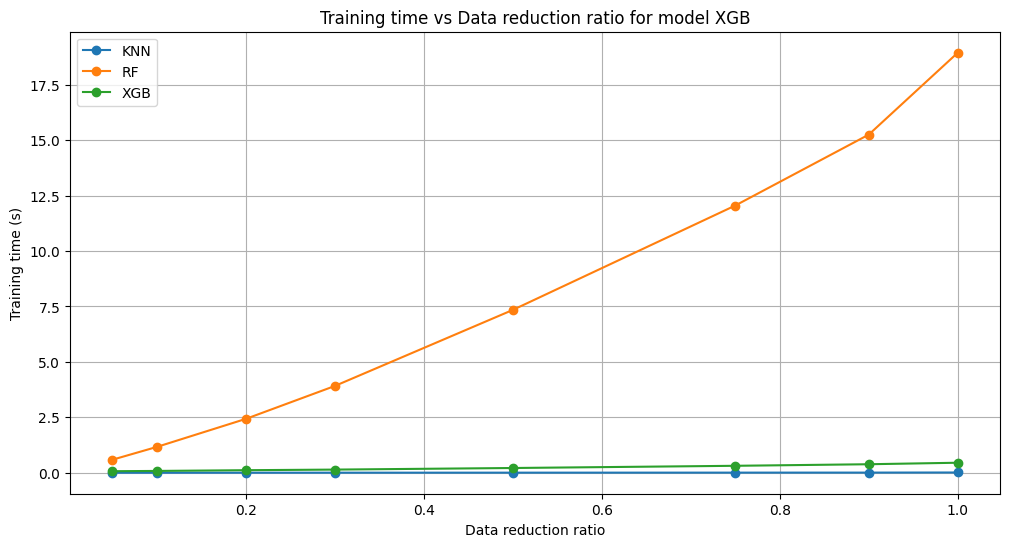

In [29]:
plot_representativeness()

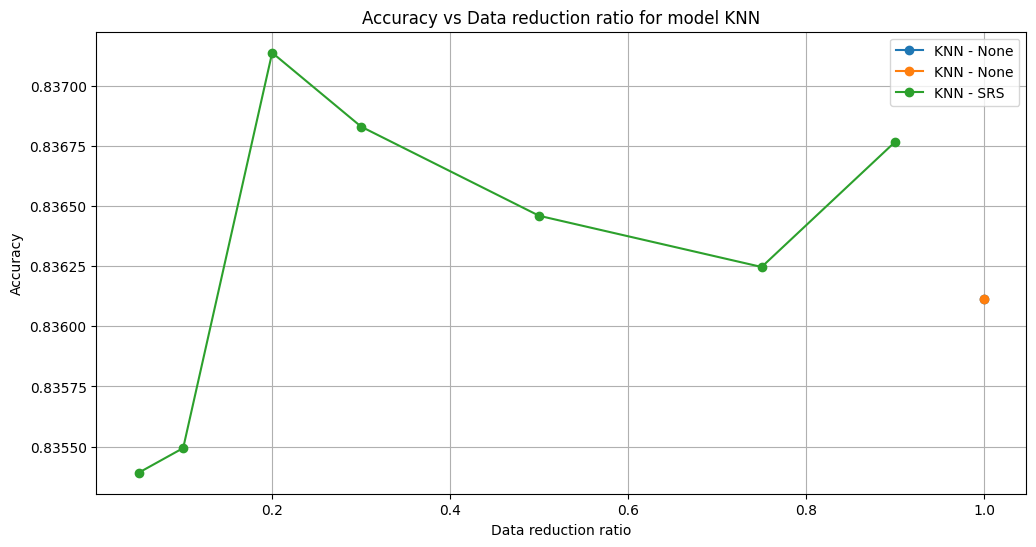

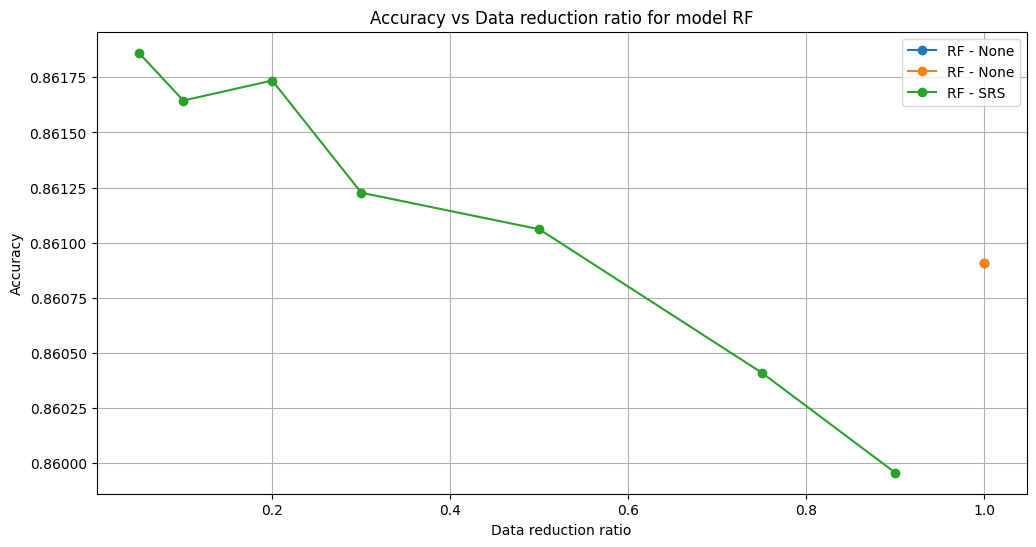

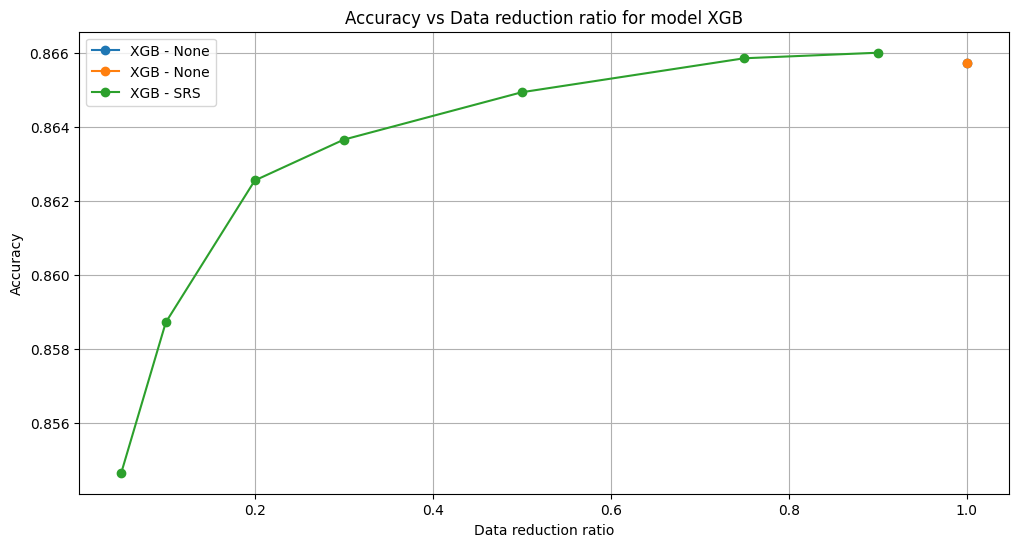

In [30]:
plot_accuracy()

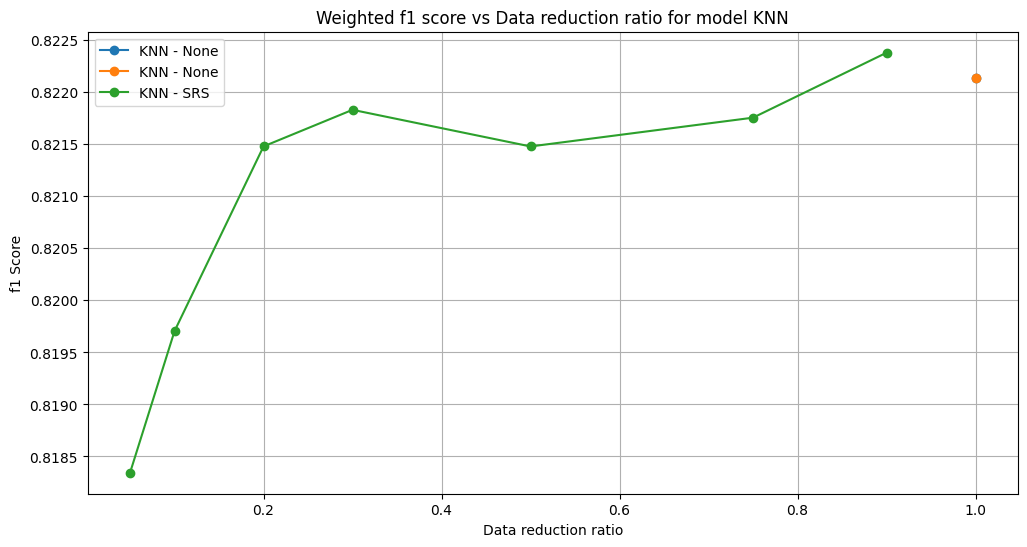

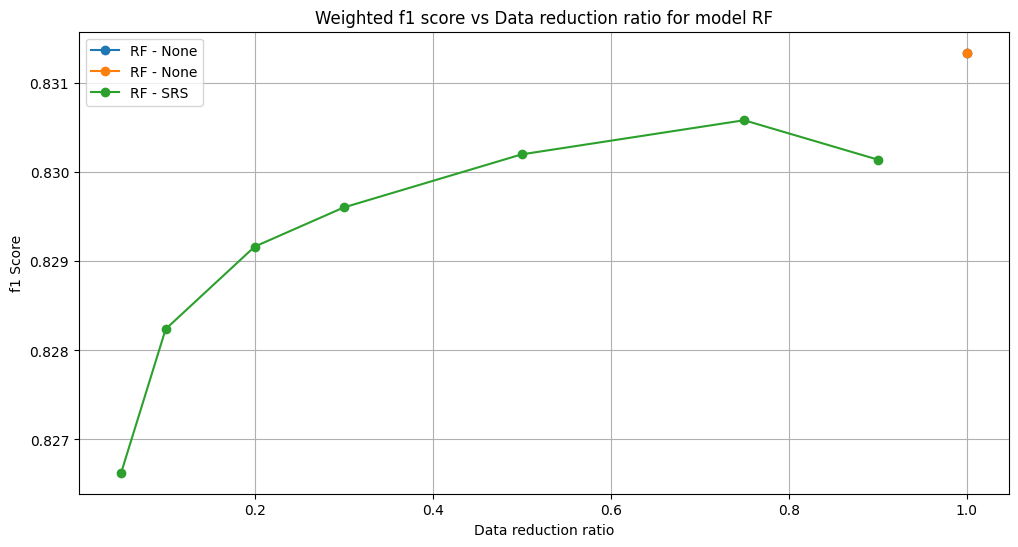

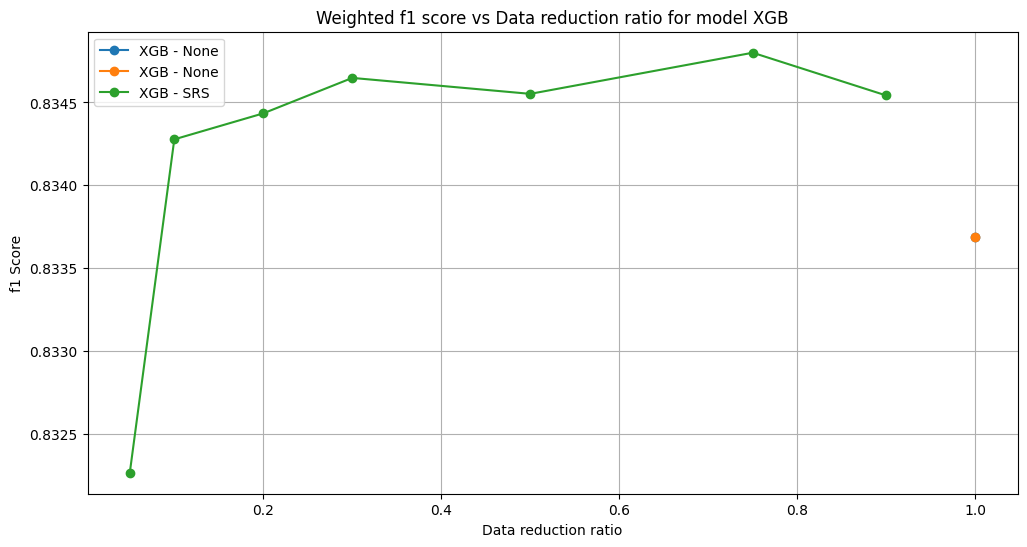

In [31]:
plot_f1()